In [2]:
# IMPORTS

import random
from neuron import h, gui
from neuron.units import ms, mV, um, V, cm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm

from time import time
import os.path

from socket import gethostname

%config InlineBackend.figure_formats = ['svg']

h.load_file('basal_project.hoc')

1.0

In [3]:
# BARDIA CELL INITIATION (ALTERED)

# spine_neck = None
# spine_head = None
# spine_neck, spine_head = add_spines(h.a1_111)

ratio=0
loc=10
nsyn=0
sec=h.a1_111

dendrec=True

print(f'\n%s .... Starting Run' % (gethostname()))
iotim = 0
tic = time()

h.tstop = 500
h.synrec = 1

h.tsamp = h.tstop/h.dt+1
h.synrec = 1
tsamp = int(h.tsamp)

r = h.Random(h.luckyoffset)
r.negexp(h.meanisi)

# Stimulated branch
# syn = h.synsuper(.5, r, sec=sec)
# syndict = dict(sloc=loc, ratio=ratio, e1flag=0)
# for name, value in syndict.items(): 
#     setattr(syn.syn, name, value)

# Initialize nseg with 'active' branches

# h.a1_111.nseg = int(np.floor(h.a1_111.L))
# h.a1_111.nseg = int(np.floor(h.a1_111.L)/2)
seclist = [h.a1_111,
           h.a9_122,
           h.a10_11,
           h.a5_1,
           h.a8_11,
           h.a3_11,
           h.a9_122,
           h.a9_121,
           h.a8_122,
           h.a8_121,
           h.a7_111]

sl2 = h.SectionList()
for sec in seclist:
    sl2.append(sec = sec)
poppedsecs = sl2.unique()
h.refreshnseg(h.makeactivelist(sl2))
print(f'nseg: %d' % (h.nsegcnt()))
h.cvode.cache_efficient(1)
h.cvode_active(0)

# somatic voltage recordings, after nseg initialization
v = h.Vector(tsamp)
v.record(h.soma(.5)._ref_v)
trash = v.label(h.soma.name())

# Voltage Recording Dictionary
vd = {'s':v}

if dendrec:
    
    # Dendritic Voltage Recording 
    
    h.distance(0, h.soma_con_pt, sec=h.soma)
    d = h.distance(0, sec=sec)
    locx = (loc - d)/sec.L
    v = h.Vector(tsamp)
    v.record(sec(locx)._ref_v)
    trash = v.label(sec.name())
    vd.update({'d':v})

h.poisson = 0

# 'background' current injection
# ic = h.IClamp(1,sec=h.soma)
# ic.dur = h.tstop


# p_tstart = 100 # plot tstart, crop initial rising phase of current injection
# ind_tstart = p_tstart/h.dt
# t = np.arange(0,h.tstop-p_tstart+h.dt,h.dt)
# fh = plt.figure(figsize=(4,8))
# for runcnt, icamp in enumerate(icamps):
#     runcnt = 1
#     ic.amp = icamp
#     syn.syn.nsyn = nsyn
#     seed1 = float(686)
#     r1 = h.Random(seed1)
#     r1.negexp(h.meanisi)
#     syn.setrand(r1)

#     # run simulation
#     h.run()

#     postrunrecgather(vd)

#     # plot voltage and synaptic current
#     ax = fh.add_subplot(6,1,runcnt+3)
#     ax.plot(t,np.array(vd['d'])[ind_tstart:],c='k',lw=1)
#     ax = fh.add_subplot(6,1,runcnt+5)
#     ax.plot(t,-(vd['nis'].sum(0)+vd['ais'].sum(0))[ind_tstart:],c='r',lw=1)
# plt.show()

dend_v = h.Vector().record(h.a1_111(0.8)._ref_v)
t = h.Vector().record(h._ref_t)
    
# h.finitialize()
h.run()

plt.plot(t, dend_v)
    
plt.xlabel('Time (ms)')
plt.ylabel('mV') 
plt.show()
stim=[]


Christophers-MacBook-Pro.local .... Starting Run
nseg: 787


ValueError: segment position range is 0 <= x <= 1

In [ ]:
######################### BIOPHYSICAL FUNCTIONS #########################

def add_spines(branches):
    
    """
    Adds spines to all branches within the branch list
    5 spines per segment on each branch
    
    Returns nested list of spines within each branch 
    """
    
    spine_head = []
    spine_neck = []
    
    num_branch = len(branches)
    for j in range(num_branch):
        
        spine_head_temp = []
        spine_neck_temp = []

        n_spines = branches[j].nseg * 5

        for i in range(n_spines):
            spine_head_temp.append(h.Section())
            spine_neck_temp.append(h.Section())

            spine_head_temp[-1].L = 0.5
            spine_head_temp[-1].diam = 0.5
            spine_head_temp[-1].Ra = 100
            spine_head_temp[-1].insert('pas')
            for seg in spine_head_temp[-1]:
                seg.pas.e = -70
                seg.pas.g = 0.00005

            spine_neck_temp[-1].L = 1.5
            spine_neck_temp[-1].diam = 0.25
            spine_neck_temp[-1].Ra = 100
            spine_neck_temp[-1].insert('pas')
            for seg in spine_neck_temp[-1]:
                seg.pas.e = -70
                seg.pas.g = 0.00005

            spine_neck_temp[-1].connect(branches[j]((i+1)/n_spines))
            spine_head_temp[-1].connect(spine_neck_temp[-1])
        spine_head.append(spine_neck_temp)
        spine_neck.append(spine_head_temp)
    
    return spine_neck, spine_head

def add_inhib_soma(num):
    """
    Adds GABA synapses to the soma
    num: number of synapses

    """

    syn_gaba_soma = []
    for i in range(num):
        syn_gaba_soma.append(h.GABAa_S(h.soma(0.5)))
        
    return syn_gaba_soma
    
def add_syn(branches, inhib=False):
    
    """
    Adds AMPA, NMDA, and GABA synaptic channels to a list of branches
    Returns three 
    """

    syn_ampa = []
    syn_nmda = []
    syn_gaba = []
    
    num_branch = len(branches)
    
    for j in range(num_branch):
        
        syn_ampa_temp = []
        syn_nmda_temp = []
        syn_gaba_temp = []
        
        # indexes spine heads of the current branch
        n_spines = len(spine_head[j])
        for i in range(n_spines):
            
            # adds AMPA, NMDA, and GABA synapses to each spine
            syn_ampa_temp.append(h.Exp2Syn(spine_head[j][i](0.5)))
            syn_nmda_temp.append(h.Exp2SynNMDA(spine_head[j][i](0.5)))
            syn_ampa_temp[-1].e = 0
            syn_ampa_temp[-1].tau1 = 0.05
            syn_ampa_temp[-1].tau2 = 0.5
            syn_nmda_temp[-1].e = 0
            syn_nmda_temp[-1].tau1 = 2.1
            syn_nmda_temp[-1].tau2 = 18.8
            
            if inhib:
                syn_gaba_temp.append(h.GABAa_S(spine_head[j][i](0.5)))
            
        syn_ampa.append(syn_ampa_temp)
        syn_nmda.append(syn_nmda_temp)
        syn_gaba.append(syn_gaba_temp)
    
    return syn_ampa, syn_nmda, syn_gaba

######################### CURRENT INJECTIONS ############################

def frequency_counter(t_vec, v_vec):
    t_tot = t_vec[-1]
    
    spike_counter = 0
    length_v = len(v_vec)
    for i in range(0, length_v-1):
        if v_vec[i] < 0 and v_vec[i+1] >= 0:
            spike_counter += 1
    
    frequency = (spike_counter/t_tot) * 10 ** 3
    
    return frequency


def fi_curve(max_c, inc, avg, g, dtb, gamma=False, inhib_dend=False):
    
    """
    Generates an FI curve through injecting increasing current into the soma
    
    max_c: the maximum amount of injected current at the soma (nA)
    inc: the size step of the amount of current (nA)
    avg: the number of times each FI point will be averaged along the curve
    """
    
    h.tstop = 500 # ms
    h.v_init = -70 # mV
    
    frequency_list = []
    
    # iterates through increasing current injections
    for amp in tqdm(np.linspace(0, max_c, int(max_c/inc + 1))):
        
        f_trial = []
        
        # performs averaged trials at a specific current value
        for j in range(avg):
            
            ncstim_ = None
            ncstim_ = background_simulation(basal_dendrites, 
                                n_gaba=25, 
                                n_excit=40,
                                n_gamma=30,
                                g=g,
                                dtb=dtb,
                                plot=False,
                                gamma=gamma,
                                inhib_dend=inhib_dend)
            
            temp = []
            temp = h.IClamp(h.soma(1))
            temp.delay = 0
            temp.dur = 1e9
            temp.amp = amp
        
            soma_v = h.Vector().record(h.soma(1)._ref_v)
            t_vec = h.Vector().record(h._ref_t)
            h.finitialize()
            h.run()
            
            stim = None
            temp = None
            
            f_trial.append(frequency_counter(t_vec, soma_v))
            ncstim_ = None
        
        frequency = np.mean(np.array(f_trial))
        frequency_list.append(frequency)
    
    amp_list = np.linspace(0, max_c, int(max_c/inc + 1))
    
    i_c = None
    stim_obj = None

    return amp_list, frequency_list

def fi_curve_current(max_c, inc, avg):
    
    """
    Generates an FI curve through injecting increasing current into the soma
    
    max_c: the maximum amount of injected current at the soma (nA)
    inc: the size step of the amount of current (nA)
    avg: the number of times each FI point will be averaged along the curve
    """
    
    h.tstop = 500 # ms
    h.v_init = -70 # mV
    
    frequency_list = []
    
    # iterates through increasing current injections
    for amp in tqdm(np.linspace(0, max_c, int(max_c/inc + 1))):
        
        f_trial = []
        
        # performs averaged trials at a specific current value
        for j in range(avg):
            
            tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
            current = np.random.normal(0.43, 2.25, len(tt))

            i_c = h.Vector()
            i_c.from_python(current)
            stim_obj = h.IClamp(h.soma(0.5))
            stim_obj.delay = 0  # ms
            stim_obj.dur = 1e9  # ms
            i_c.play(stim_obj._ref_amp, tt, True)
            
            temp = []
            temp = h.IClamp(h.soma(1))
            temp.delay = 0
            temp.dur = 1e9
            temp.amp = amp
        
            soma_v = h.Vector().record(h.soma(1)._ref_v)
            t_vec = h.Vector().record(h._ref_t)
            h.finitialize()
            h.run()
            
            stim = None
            temp = None
            
            f_trial.append(frequency_counter(t_vec, soma_v))
            ncstim_ = None
            
            tt = None
            current = None
            i_c = None
            stim_obj = None
            ncstim_= None
        
        frequency = np.mean(np.array(f_trial))
        frequency_list.append(frequency)
    
    amp_list = np.linspace(0, max_c, int(max_c/inc + 1))
    
    i_c = None
    stim_obj = None

    return amp_list, frequency_list

##################### SYNAPSE BEHAVIOR ##########################

def background_simulation(branches, 
                          n_gaba, 
                          n_excit,
                          n_gamma,
                          g,
                          firing=[5, 5, 50, 50],
                          dtb=[20, 20],
                          plot=True, 
                          inhib_dend=False,
                          rand=True,
                          gamma=False):
    
    """
    Simulates background synapses along basal dendrites,
    in which the soma has basket cell-like inhibitory synapses
    along with excitatory inputs coming in from surrounding dendrites
    
    Firing rate is fixed to 5 Hz with a Guassian distribution of start times
    
    branches: list of branches
    n_gaba: number of GABA synapses at the soma
    n_excit: number of excitatory synapses being activated (spread across dendrites) 
    g: list of conductances for [gaba, ampa, nmda, gamma_ampa, gamma_nmda] (µS)
    firing: list of firing rates for [inhib, excit, gamma, gamma_inhib] [5, 5, 50, 50 Hz default]
    dtb: std of distribution for firing rates [inhib, excit] [Hz]
    inhib_dend: determines whether we choose to add GABA to dendrites (vs. just soma)
    rand: randomizes distribution of each theta cycle
    gamma: determines whether to add gamma rythm
    """
    
    # Add syns to the soma
    syn_gaba_soma = add_inhib_soma(n_gaba)
    
    # Time between "humps"
    interval_inhib = 1000/firing[0]
    
    # GABA Stimulations; all fire at 5 Hz (no noise) at Gaussian-distributed start times
    syn_stim_gaba = []
    
    if inhib_dend:
        syn_stim_gamma_inhib = []
        interval_gamma = 1000/firing[3]
        for i in range(firing[3]):
            gamma_start_distribution = np.random.normal(0, dtb[2], n_gamma)
            
            for j in range(n_gamma):
                syn_stim_gamma_inhib.append(create_stim(interval=1000/firing[3],
                                                  num=1,
                                                  start=gamma_start_distribution[j]+interval_gamma*i,
                                                  noise=0,
                                                  s=1))
    
    if rand:

        for q in range(firing[1]):
    
            # Distribution of time shift for GABA synapses
            gaba_start_distribution = np.random.normal(0, dtb[0], n_gaba)

            # GABA Stimulations; all fire at 5 Hz (no noise) at Gaussian-distributed start times
            for i in range(n_gaba):
                syn_stim_gaba.append(create_stim(interval=1000/firing[0],
                                             num=1,
                                             start=gaba_start_distribution[i]+interval_inhib*q,
                                             noise=0,
                                             s=1))
    else:
        
        # Distribution of time shift for GABA synapses
        gaba_start_distribution = np.random.normal(0, dtb[0], n_gaba)
        for i in range(n_gaba):
            syn_stim_gaba.append(create_stim(interval=1000/firing[0],
                                             num=1e9,
                                             start=gaba_start_distribution[i],
                                             noise=0,
                                             s=1))
    
    interval_excite = 1000/firing[1]
        
    # NMDA/AMPA Simulations; all fire at 5 Hz (no noise) at Gaussian-distributed start times
    syn_stim_ampa = []
    syn_stim_nmda = []
    
    if rand:
        
        for q in range(firing[1]):
    
            excit_start_distribution = np.random.normal(0, dtb[1], n_excit)

            for i in range(n_excit):
                syn_stim_ampa.append(create_stim(interval=1000/firing[1],
                                                 num=1,
                                                 start=100+excit_start_distribution[i] + interval_excite*q,
                                                 noise=0,
                                                 s=1))
                syn_stim_nmda.append(create_stim(interval=1000/firing[1],
                                                 num=1,
                                                 start=100+excit_start_distribution[i] + interval_excite*q,
                                                 noise=0,
                                                 s=1))
        
    else:
        
        excit_start_distribution = np.random.normal(0, dtb[1], n_excit)
        for i in range(n_excit):
            syn_stim_ampa.append(create_stim(interval=1000/firing[1],
                                             num=1e9,
                                             start=100+excit_start_distribution[i],
                                             noise=0,
                                             s=1))
            syn_stim_nmda.append(create_stim(interval=1000/firing[1],
                                             num=1e9,
                                             start=100+excit_start_distribution[i],
                                             noise=0,
                                             s=1))
    
    if gamma:
        # stimuation object for gamma rythm (only requires 1 since uniform/synchronous)
        syn_stim_gamma_inhib = create_stim(interval=1000/firing[2],
                                    num=1e9,
                                    start=0,
                                    noise=0,
                                    s=1)
        
    
    num_branch = len(branches)
    ncstim = []
    
    
    if rand:
        for q in range(firing[0]):  
            c = 0 # cluster shift (after all dendrites are added to, we add to the next index on the dendrite)
            n_s = 0 # number of synapses attached
            i = 1 # index for which branch (skips dendrite of interest)
            while n_s != n_gaba:

                # Now we have to find where we are indexing; we want to place them at ~25 um

#                 if inhib_dend:
#                     branch_i = branches[i]
#                     branch_L = branch_i.L
#                     branch_nseg = branch_i.nseg
#                     loc = int(np.floor(25/branch_L * branch_nseg)) # starts 25 microns out

#                     ncstim.append(h.NetCon(syn_stim_gaba[n_s+q*n_gaba], syn_gaba[i][loc+c], 0, 0, g[0]))
#                     ncstim.append(h.NetCon(syn_stim_gaba[n_s+q*n_gaba], syn_gaba_soma[n_s], 0, 0, g[0]))
#                     n_s += 1
#                     i += 1
                
                ncstim.append(h.NetCon(syn_stim_gaba[n_s+q*n_gaba], syn_gaba_soma[n_s], 0, 0, g[0]))                       
                n_s += 1
                i += 1

                if i == num_branch - 1:
                    i = 1
                    c += 1
    
        for q in range(firing[1]):
            n_s = 0
            c = 0
            i = 1
            while n_s < n_excit:    


                # Now we have to find where we are indexing; we want to place them at ~25 um
                branch_i = branches[i]
                branch_L = branch_i.L
                branch_nseg = branch_i.nseg
                loc = int(np.floor(25/branch_L * branch_nseg))

                ncstim.append(h.NetCon(syn_stim_ampa[n_s+q*n_excit], syn_ampa[i][loc+2*c], 0, 0, g[1]))
                ncstim.append(h.NetCon(syn_stim_nmda[n_s+q*n_excit], syn_nmda[i][loc+2*c], 0, 0, g[2]))
                n_s += 1
                i += 1

                if i == num_branch - 1:
                    i = 1
                    c = c + 1
                    
        if gamma:
            n_s = 0
            c = 0
            i = 1
            while n_s < n_gamma:
                branch_i = branches[i]
                branch_L = branch_i.L
                branch_nseg = branch_i.nseg
                loc = int(np.floor(25/branch_L * branch_nseg))

                ncstim.append(h.NetCon(syn_stim_gamma, syn_ampa[i][loc+1+2*c], 0, 0, g[3]))
                ncstim.append(h.NetCon(syn_stim_gamma, syn_nmda[i][loc+1+2*c], 0, 0, g[4]))
                n_s += 1
                i += 1

                if i == num_branch - 1:
                    i = 1
                    c = c + 1
                    
        
    else:
        n_s = 0 # number of synapses attached
        c = 0 # cluster shift (after all dendrites are added to, we add to the next index on the dendrite)
        i = 1 # index for which branch (skips dendrite of interest)
        while n_s != n_gaba:

            # Now we have to find where we are indexing; we want to place them at ~25 um

#             if inhib_dend:
#                 branch_i = branches[i]
#                 branch_L = branch_i.L
#                 branch_nseg = branch_i.nseg
#                 loc = int(np.floor(25/branch_L * branch_nseg)) # starts 25 microns out

#                 ncstim.append(h.NetCon(syn_stim_gaba[n_s], syn_gaba[i][loc+c], 0, 0, g[0]))
#                 ncstim.append(h.NetCon(syn_stim_gaba[n_s], syn_gaba_soma[n_s], 0, 0, g[0]))
#                 n_s += 1
#                 i += 1
            
            ncstim.append(h.NetCon(syn_stim_gaba[n_s], syn_gaba_soma[n_s], 0, 0, g[0]))                       
            n_s += 1
            i += 1

            if i == num_branch - 1:
                i = 1
                c += 1

        n_s = 0
        c = 0
        i = 1
        while n_s < n_excit:    


            # Now we have to find where we are indexing; we want to place them at ~25 um
            branch_i = branches[i]
            branch_L = branch_i.L
            branch_nseg = branch_i.nseg
            loc = int(np.floor(25/branch_L * branch_nseg))

            ncstim.append(h.NetCon(syn_stim_ampa[n_s], syn_ampa[i][loc+2*c], 0, 0, g[1]))
            ncstim.append(h.NetCon(syn_stim_nmda[n_s], syn_nmda[i][loc+2*c], 0, 0, g[2]))
            n_s += 1
            i += 1

            if i == num_branch - 1:
                i = 1
                c = c + 1
    
        if gamma:
            n_s = 0
            c = 0
            i = 1
            while n_s < n_gamma:
                branch_i = branches[i]
                branch_L = branch_i.L
                branch_nseg = branch_i.nseg
                loc = int(np.floor(25/branch_L * branch_nseg))

                ncstim.append(h.NetCon(syn_stim_gamma, syn_ampa[i][loc+1+2*c], 0, 0, g[3]))
                ncstim.append(h.NetCon(syn_stim_gamma, syn_nmda[i][loc+1+2*c], 0, 0, g[4]))
                n_s += 1
                i += 1

                if i == num_branch - 1:
                    i = 1
                    c = c + 1
                    
    if inhib_dend:
        for q in range(firing[3]):
            n_s = 0
            c = 0
            i = 1
            while n_s < n_gamma:
                branch_i = branches[i]
                branch_L = branch_i.L
                branch_nseg = branch_i.nseg
                loc = int(np.floor(25/branch_L * branch_nseg))

                ncstim.append(h.NetCon(syn_stim_gamma_inhib[n_s+q*n_gamma], syn_gaba[i][loc+1+2*c], 0, 0, g[5]))
                n_s += 1
                i += 1

                if i == num_branch - 1:
                    i = 1
                    c = c + 1
    
    if plot:
        soma_v = h.Vector().record(h.soma(0.7)._ref_v)
        t_vec = h.Vector().record(h._ref_t)

        h.finitialize()
        h.run()
        plt.plot(t_vec, soma_v)
    if gamma:
        return ncstim, syn_stim_ampa, syn_stim_nmda, syn_stim_gaba, syn_gaba_soma, syn_stim_gamma
    elif inhib_dend:
        return ncstim, syn_stim_ampa, syn_stim_nmda, syn_stim_gaba, syn_gaba_soma, syn_stim_gamma_inhib
    else:
        return ncstim, syn_stim_ampa, syn_stim_nmda, syn_stim_gaba, syn_gaba_soma

def create_stim(interval=10, num=3, start=5, noise=0, s=1):
    
    """
    Creates a stimulator object used as the pre-synaptic stimulus
    interval: amount of time between stimulation events (ms)
    num: the number of stimulation events
    start: delay of stimulation (ms)
    s: seed number
    """
    
    stim = h.NetStim()
    stim.interval = interval
    stim.number = num
    stim.start = start
    stim.noise = noise

    if s == 1:
        stim.seed(np.random.randint(1000000))
    else:
        stim.seed(s)
    
    return stim

def increase_syn(branch, 
                 loc, 
                 n_syn, 
                 stim, 
                 g, 
                 spread,
                 avg=1,
                 g_bg=[0.029, 0.00, 0.034, 0, 0],
                 firing=[5, 5, 0],
                 dtb=[15, 15],
                 gamma=True,
                 stim_spread=0,
                 distribute=False,
                 sync=True,
                 inhib_dend=False,
                 plot=True,
                 progress_bar=False):
    
    """
    IO curve that measures somatic response with signal NMDA+AMPA synapses under a
    number of parameters for signal input with SYNAPTIC NOISY BACKGROUND (FS CURVE)
    
    branch: branch being stimulated (h.XXXXX)
    loc: fraction of distance from end to end of the dendrite
    n_syn: total number of synapses being added to the dendrite
    g: conductance of signal synapses; [AMPA, NMDA]
    spread: spread of signal synapses (by index number)
    avg: number of trials being run
    g_bg: conductance of background synapses [gaba, theta_ampa, theta_nmda, gamma_ampa, gamma_nmda]
    firing: frequency of background synapses [gaba, theta, gamma] [Hz]
    dtb: distribution of theta rythms (variance of curves)
    gamma: boolean, determines whether to add gamma rhythm
    stim_spread: staggers start times of each synapse by ___ ms
    distribute: distributes the signal synapses across the dendrites, otherwise focal
    sync: synchronizes all synapses (BOOLEAN)
    plot: plots the voltage traces for each FS curve along with the FS curve
    progress_bar: boolean, determines if there should be a progress bar for EACH trial
    """
    
    loc_n = int(np.floor(len(syn_ampa[0])*loc))
    loc_um = int(np.floor(branch.L*loc))
    
    print('Applying synapses at ~' + str(loc_um) + ' µm (' + str(branch.L) + ' µm total)')
    
    f_vec = np.zeros((1, n_syn), dtype=float)
    
    # plot for voltage traces; only useful if avg=1
    if plot:
        plt.figure(figsize=(10, 8))
        
    for j in tqdm(range(avg)):
        
        if j > 0:
            f_vec = np.vstack([f_vec, np.zeros((1, n_syn), dtype=float)])
        
        h.v_init = -70
    
        ncstim = []
        f = []
        
        syn_stims = []
        
        if sync:
            syn_stims.append(create_stim(interval=stim[0],
                                         num=stim[1],
                                         start=stim[2],
                                         noise=stim[3],
                                         s=stim[4]))
        
        else:
            for q in range(n_syn):
                syn_stims.append(create_stim(interval=stim[0],
                                             num=stim[1],
                                             start=stim[2]+q*stim_spread,
                                             noise=stim[3],
                                             s=stim[4]))
        
        for i in tqdm(range(n_syn), disable=not(progress_bar)):

            y=i
            ncstim_ = None
            ncstim_ = background_simulation(basal_dendrites, 
                                            n_gaba=25, 
                                            n_excit=40,
                                            n_gamma=30,
                                            firing=firing,
                                            dtb=dtb,
                                            g=g_bg,
                                            plot=False,
                                            gamma=gamma,
                                            inhib_dend=inhib_dend)
            
            
            if sync:
                y=0
            
            if distribute:
                
                syn_loc = poisson_syn_weight(branch=branch, start=30)
                loc_n = int(np.floor(len(syn_ampa[0])*syn_loc))
                
                ncstim.append(h.NetCon(syn_stims[y], syn_ampa[0][loc_n], 0, 0, g[0]))
                ncstim.append(h.NetCon(syn_stims[y], syn_nmda[0][loc_n], 0, 0, g[1])) # gMax
            
            else:
                ncstim.append(h.NetCon(syn_stims[y], syn_ampa[0][loc_n+spread*i], 0, 0, g[0]))
                ncstim.append(h.NetCon(syn_stims[y], syn_nmda[0][loc_n+spread*i], 0, 0, g[1])) # gMax

            soma_v = h.Vector().record(h.soma(0.5)._ref_v)
            t_vec = h.Vector().record(h._ref_t)

            h.finitialize()
            h.run()
            if plot:
                plt.plot(t_vec, soma_v, label=str(i+1))

            f.append(frequency_counter(t_vec, soma_v))

            current = None
            i_c = None
            stim_obj = None
            ncstim_= None

        f_vec[-1, :] = f
    
    # AVERAGES RUN DATA
    f = f_vec.mean(axis=0)
    
    if plot:
        plt.legend()
        plt.xlabel('Time (ms)')
        plt.ylabel('Somatic Voltage (mV)')
        plt.title('Increasing Number of Synapses')
    
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(f_vec.mean(axis=0))
        plt.title('FS Curve')
        plt.xlabel('# of Synapses')
        plt.ylabel('Somatic Frequency (Hz)')
    
    ncstim = None
    syn_stim = None
    
    return f

def increase_syn_current(branch, 
                         loc,
                         mean,
                         var,
                         n_syn, 
                         stim, 
                         g, 
                         spread,
                         avg=1,
                         stim_spread=0,
                         distribute=False,
                         sync=True,
                         plot=True, 
                         progress_bar=False):
    
    """
    IO curve that measures somatic response with signal NMDA+AMPA synapses under a
    number of parameters for signal input with NOISY CURRENT BACKGROUND (FS CURVE)
    
    branch: branch being stimulated (h.XXXXX)
    loc: fraction of distance from end to end of the dendrite
    n_syn: total number of synapses being added to the dendrite
    mean: average current injection at soma (nA)
    var: variance of current injection at soma (nA)
    g: conductance of signal synapses; [AMPA, NMDA]
    spread: spread of signal synapses (by index number)
    avg: number of trials being run
    stim_spread: staggers start times of each synapse by ___ ms
    distribute: distributes the signal synapses across the dendrites, otherwise focal
    sync: synchronizes all synapses (BOOLEAN)
    plot: plots the voltage traces for each FS curve along with the FS curve
    progress_bar: boolean, determines if there should be a progress bar for EACH trial
    """
    
    loc_n = int(np.floor(len(syn_ampa[0])*loc))
    loc_um = int(np.floor(branch.L*loc))
    
    print('Applying synapses at ~' + str(loc_um) + ' µm (' + str(branch.L) + ' µm total)')
    
    f_vec = np.zeros((1, n_syn), dtype=float)
    
    
    if plot:
        plt.figure(figsize=(10, 8))
    for j in tqdm(range(avg)):
        
        if j > 0:
            f_vec = np.vstack([f_vec, np.zeros((1, n_syn), dtype=float)])
        
        h.v_init = -70
        ncstim = []
        f = []
        
        syn_stims = []
        if sync:
            syn_stims.append(create_stim(interval=stim[0],
                                         num=stim[1],
                                         start=stim[2],
                                         noise=stim[3],
                                         s=stim[4]))
        else:
            for q in range(n_syn):
                syn_stims.append(create_stim(interval=stim[0],
                                             num=stim[1],
                                             start=stim[2]+stim_spread*q,
                                             noise=stim[3],
                                             s=stim[4]))
        
        for i in tqdm(range(n_syn), disable=not(progress_bar)):
            
            y = i
            
            # creation of background noisy current
            tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
            current = np.random.normal(mean, var, len(tt)) 
            i_c = h.Vector()
            i_c.from_python(current)
            stim_obj = h.IClamp(h.soma(0.5))
            stim_obj.delay = 0  # ms
            stim_obj.dur = 1e9  # ms
            i_c.play(stim_obj._ref_amp, tt, True)
            
            
            if sync:
                y = 0
                
            if distribute:
                syn_loc = poisson_syn_weight(branch=branch, start=30)
                loc_n = int(np.floor(len(syn_ampa[0])*syn_loc))
                ncstim.append(h.NetCon(syn_stims[y], syn_ampa[0][loc_n], 0, 0, g[0]))
                ncstim.append(h.NetCon(syn_stims[y], syn_nmda[0][loc_n], 0, 0, g[1])) # gMax
                
            else:
                ncstim.append(h.NetCon(syn_stims[y], syn_ampa[0][loc_n+spread*i], 0, 0, g[0]))
                ncstim.append(h.NetCon(syn_stims[y], syn_nmda[0][loc_n+spread*i], 0, 0, g[1])) # gMax
                
            soma_v = h.Vector().record(h.soma(0.5)._ref_v)
            t_vec = h.Vector().record(h._ref_t)
                
            h.finitialize()
            h.run()
            if plot:
                plt.plot(t_vec, soma_v, label=str(i+1))
                
            f.append(frequency_counter(t_vec, soma_v))
                
            tt = None
            current = None
            i_c = None
            stim_obj = None
            ncstim_=None
                
        f_vec[-1, :] = f
                 
    # AVERAGES RUN DATA
    f = f_vec.mean(axis=0)
                
    if plot:     
        plt.legend()
        plt.xlabel('Time (ms)')
        plt.ylabel('Somatic Voltage (mV)')
        plt.title('Increasing Number of Synapses')
    
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(f_vec.mean(axis=0))
        plt.title('FS Curve')
        plt.xlabel('# of Synapses')
        plt.ylabel('Somatic Frequency (Hz)')
    
    ncstim = None
    syn_stim = None
    
    return f


def apply_syn_cluster(branch, 
                      measure, 
                      loc, 
                      n_syn, 
                      stim_obj, 
                      g, 
                      spread, 
                      plot=True, 
                      xlim=1, 
                      ylim=1, 
                      sync=False,
                      stim_spread=0,
                      distribute=False):
    
    """
    Applies a number of synapses at a specified location, giving a stimulus object
    Can be used to look at voltage traces of synapses, typically with a background current
    
    branch: branch being activated
    measure: branch(loc) where voltage is recorded from
    loc: location of applied synapses along dendrite (decimal)
    stim: stimulation parameters
    g: conductance of AMPA/NMDA
    spread: how far apart synapses are (index based)
    """
    
    loc_n = int(np.floor(len(syn_ampa[0])*loc))
    loc_um = int(np.floor(branch.L*loc))
    
    print('Applying synapses at ~' + str(loc_um) + ' um (' + str(branch.L) + ' um total)')
    
    ncstim1 = []

    syn_stims1 = []
    
    if sync:
        syn_stims1.append(create_stim(interval=stim_obj[0],
                                         num=stim_obj[1],
                                         start=stim_obj[2],
                                         noise=stim_obj[3],
                                         s=stim_obj[4]))
    else:
        for i in range(n_syn):
            syn_stims1.append(create_stim(interval=stim_obj[0],
                                         num=stim_obj[1],
                                         start=stim_obj[2]+stim_spread*i,
                                         noise=stim_obj[3],
                                         s=stim_obj[4]))
        
    
    if plot:
        plt.figure(figsize=(10, 8))
    for i in tqdm(range(n_syn)):
        j=i
        if sync:
            j=0
            
        if distribute:
                syn_loc = poisson_syn_weight(branch=branch, start=30)
                loc_n = int(np.floor(len(syn_ampa[0])*syn_loc))
                ncstim1.append(h.NetCon(syn_stims1[j], syn_ampa[0][loc_n], 0, 0, g[0]))
                ncstim1.append(h.NetCon(syn_stims1[j], syn_nmda[0][loc_n], 0, 0, g[1])) # gMax
        else:       
            ncstim1.append(h.NetCon(syn_stims1[j], syn_ampa[0][loc_n+spread*i], 0, 0, g[0]))
            ncstim1.append(h.NetCon(syn_stims1[j], syn_nmda[0][loc_n+spread*i], 0, 0, g[1])) # gMax
        
    soma_v = h.Vector().record(measure._ref_v)
    t_vec = h.Vector().record(h._ref_t)
        
    h.finitialize()
    h.run()
    if plot:
        plt.plot(t_vec, soma_v, label=str(i+1))
            
    f = frequency_counter(t_vec, soma_v)
    
    plt.legend()
    plt.xlabel('Time (ms)')
    if xlim != 1:
        plt.xlim(xlim[0], xlim[1])
    if ylim != 1:   
        plt.ylim(ylim[0], ylim[1])
    plt.ylabel('Somatic Voltage (mV)')
    plt.title('Voltage Trace')
    
    ncstim1 = None
    syn_stims1 = None
    
    return f, soma_v, t_vec

def background_rate(avg, 
                    n_g, 
                    n_e,
                    n_ga,
                    g,
                    firing=[5,5,50],
                    dtb=[20, 20],
                    plot=False, 
                    xlim=1, 
                    ylim=1,
                    rand=True,
                    gamma=True,
                    inhib_dend=False):

    """
    
    Returns the firing rate with ONLY background current injection (injected at the soma)
    Noisy current created using mean and variance parameters
    Optional: plots the trace at the soma
    
    """
    
    h.v_init = -70
    h.tstop = 1000
    
    

    freq = []
    for q in tqdm(range(avg)):
        
        ncstim_ = background_simulation(branches=basal_dendrites, 
                                      n_gaba=n_g, 
                                      n_excit=n_e,
                                      n_gamma=n_ga,
                                      g=g,
                                      firing=firing,
                                      dtb=dtb,
                                      plot=False, 
                                      inhib_dend=inhib_dend,
                                      rand=rand,
                                      gamma=gamma)
    
        soma_v = h.Vector().record(h.soma(0.5)._ref_v)
        t_vec = h.Vector().record(h._ref_t)
        
        h.finitialize()
        h.run()
    
        freq.append(frequency_counter(t_vec, soma_v))
        ncstim_ = None
    
    if plot:
        plt.plot(t_vec, soma_v)
        plt.title('Voltage Trace of Noisy Current')
        plt.xlabel('Time (ms)')
        plt.ylabel('Somatic Voltage (mV)')
        if xlim != 1:
            plt.xlim(xlim[0], xlim[1])
        if ylim != 1:
            plt.ylim(ylim[0], ylim[1])
    
    mean_rate = float(np.mean(freq))
    print('The average background firing rate is ', str(mean_rate) + ' Hz')
    
    ncstim_ = None
    s_ampa = None
    s_nmda = None
    s_gaba = None
    syn_gaba_soma = None
    
    return np.mean(freq)

def background_rate_current(avg,
                            mean,
                            var,
                            plot=False, 
                            xlim=1, 
                            ylim=1):

    """
    
    Returns the firing rate with ONLY background current injection (injected at the soma)
    Noisy current created using mean and variance parameters
    Optional: plots the trace at the soma
    
    """
    
    h.v_init = -70
    h.tstop = 1000
    
    

    freq = []
    for q in tqdm(range(avg)):
        
        tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
        current = np.random.normal(mean, var, len(tt))

        i_c = h.Vector()
        i_c.from_python(current)
        stim_obj = h.IClamp(h.soma(0.5))
        stim_obj.delay = 0  # ms
        stim_obj.dur = 1e9  # ms
        i_c.play(stim_obj._ref_amp, tt, True)
    
        soma_v = h.Vector().record(h.soma(0.5)._ref_v)
        t_vec = h.Vector().record(h._ref_t)
        
        h.finitialize()
        h.run()
    
        freq.append(frequency_counter(t_vec, soma_v))
        ncstim_ = None
        tt = None
        current = None
        i_c = None
        stim_obj = None
        ncstim_=None
    
    if plot:
        plt.plot(t_vec, soma_v)
        plt.title('Voltage Trace of Noisy Current')
        plt.xlabel('Time (ms)')
        plt.ylabel('Somatic Voltage (mV)')
        if xlim != 1:
            plt.xlim(xlim[0], xlim[1])
        if ylim != 1:
            plt.ylim(ylim[0], ylim[1])
    
    mean_rate = float(np.mean(freq))
    print('The average background firing rate is ', str(mean_rate) + ' Hz')
    
    ncstim_ = None
    s_ampa = None
    s_nmda = None
    s_gaba = None
    syn_gaba_soma = None
    
    return np.mean(freq)

def f_to_i(f_vec_FS, f_vec_FI, i_vec_FI):
    
    num_syn = len(f_vec_FS)
    len_FI = len(f_vec_FI)
    
    corr_vec = [] # correlation vector
    corr_vec.append(i_vec_FI[0])
    
    for i in range(num_syn):
        f = f_vec_FS[i] # frequency of FS curve that we want to match to current
        
        # find the abs. differences from the remaining frequencies
        dif_vec = abs(f_vec_FI - f)

        
        # closest difference value
        closest = min(abs(f_vec_FI - f))

        
        indexes = [q for q, r in enumerate(dif_vec) if r == closest]
        
        loopFlag = True
        j = 0
        while loopFlag:
            ind_min = indexes[j]
            if (i_vec_FI[ind_min] > corr_vec[i]) | (j == len(indexes) - 1):
                corr_vec.append(i_vec_FI[ind_min])
                loopFlag = False
            else:
                j += 1
        
    return corr_vec

def poisson_syn_weight(branch, start=30):
    """
    n_syn: Number of syns being simulated
    branch: Branch being simulated
    start: point at which the synapses can start to attach (µm)
    """
    
    n_syn = 1
    incorrect_num = True
    while incorrect_num:

        n_bins_fix = int(np.floor(  (start/branch.L)*branch.nseg ))

        nbins = branch.nseg - n_bins_fix
        prob_vec = np.linspace(3, 1, nbins)
        sum_prob = np.sum(prob_vec)
        prob_of_syn = n_syn*prob_vec/sum_prob

        syns = np.random.rand(nbins) < prob_of_syn
        syns = syns * 1
        no_syns_region = np.zeros(n_bins_fix)
        syns = np.concatenate((no_syns_region, syns), axis=0)

        num_events = np.sum(syns)
        if num_events == int(n_syn):
            incorrect_num = False
    
    ln_syns = len(list(syns))

    index = list(syns).index(1)
    syn_loc = index/ln_syns
        
    return syn_loc

In [ ]:
basal_dendrites = [h.a1_111,
                   h.a9_122,
                   h.a10_11,
                   h.a5_1,
                   h.a8_11,
                   h.a3_11,
                   h.a9_122,
                   h.a9_121,
                   h.a8_122,
                   h.a8_121,
                   h.a7_111]

In [ ]:
spine_neck, spine_head = add_spines(basal_dendrites)
syn_ampa, syn_nmda, syn_gaba = add_syn(basal_dendrites, inhib=True)

In [ ]:
# DETERMINE BACKGROUND RATE OF SYNAPTIC BACKGROUND #
adjust = h.IClamp(h.soma(1))
adjust.delay = 0
adjust.dur = 1e9
adjust.amp = 1.45

background_rate(avg=15, 
                n_g=0, 
                n_e=0,
                n_ga=30,
                firing=[5, 5, 50, 50],
                dtb=[20,20, 3],
                g=[0, 0, 0, 0, 0, 0.0025],
                rand=True,
                gamma=False,
                plot=False,
                inhib_dend=True)

adjust = None

  0%|          | 0/15 [00:00<?, ?it/s]

The average background firing rate is  0.8000000000002895 Hz


In [ ]:
adjust = None

In [ ]:
# Determine injected current background rate
background_rate_current(avg=20, 
                        mean=0.0, 
                        var=4)

In [ ]:
# VOLTAGE TRACE FOR BACKGROUND SYNAPTIC INPUT ONLY

h.tstop = 1000

# NOTE: MUST CLEAR NCSTIM_, otherwise, there is OVERLAP!
ncstim_ = None
np.random.seed(1)
ncstim_ = background_simulation(basal_dendrites, 
                                n_gaba=25, 
                                n_excit=40,
                                n_gamma=30,
                                firing=[5, 5, 50],
                                dtb=[20, 20],
                                g=[0.029, 0.008, 0.0208, 0.0032, 0],
                                rand=True,
                                gamma=True)

ncstim_ = None

NameError: name 'syn_stim_gamma' is not defined

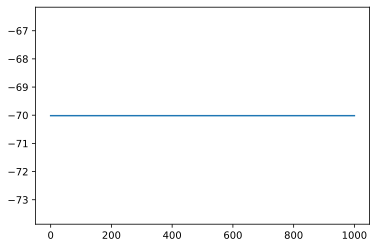

In [ ]:
# PLOT OF RESTING CELL (CHECK FOR REMAINING STIMULUS OBJECTS):

ncstim_ = None
soma_v = h.Vector().record(h.soma(0.7)._ref_v)
t_vec = h.Vector().record(h._ref_t)
        
h.finitialize()
h.run()

plt.plot(t_vec, soma_v)

In [ ]:
############ TESTING ############

# NOTE: MUST CLEAR NCSTIM_, otherwise, there is OVERLAP!
ncstim_ = None


ncstim_ = background_simulation(basal_dendrites,
                                n_gaba=25,
                                n_excit=40,
                                n_gamma=30,
                                firing=[5, 5, 50, 50],
                                dtb=[20, 20, 3],
                                g=[0, 0, 0, 0, 0, 0.011],
                                gamma=False,
                                plot=False,
                                inhib_dend=True)


adjust = h.IClamp(h.soma(1))
adjust.delay = 0
# adjust.dur = 1e9
# adjust.amp = 3.35

# tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
# current = np.random.normal(0.82, 1, len(tt))
# i_c = h.Vector()
# i_c.from_python(current)
# stim_obj = h.IClamp(h.soma(0.5))
# stim_obj.delay = 0  # ms
# stim_obj.dur = 1e9  # ms
# i_c.play(stim_obj._ref_amp, tt, True)

# tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
# t = np.linspace(0, h.tstop, int(h.tstop/h.dt))
# current = 0.88 + 0.5*np.sin(2*np.pi/20*t)
# i_c = h.Vector()
# i_c.from_python(current)
# stim_obj = h.IClamp(h.soma(0.5))
# stim_obj.delay = 0  # ms
# stim_obj.dur = 1e9  # ms
# i_c.play(stim_obj._ref_amp, tt, True)

# apply synapses and analyze voltage traces
h.tstop = 1000

num_s = 1

# stim_param = [interval, num, start, noise, seed]
stim_param =   [1000/50,  1e9,   0,     0,     2]

f, volt, time = apply_syn_cluster(branch=h.a1_111,
                 loc=0.5,
                 measure=h.soma(0.5),
                 n_syn=num_s,
                 stim_obj=stim_param,
                 g=[0.0015, 0.0039],
                 spread=0,
                 plot=True,
                 sync=True,
                 stim_spread=0,
                 distribute=True)

adjust = None

tt = None
current = None
i_c = None
stim_obj = None
ncstim_ = None
tt = None

IndexError: list index out of range

In [ ]:
# SAVE VOLTAGE TRACE

np.savetxt('SIN_1_20.csv', np.vstack((time, volt)).T, delimiter=', ')

Applying synapses at ~121 µm (243.8985804846295 µm total)


  0%|          | 0/1 [00:00<?, ?it/s]

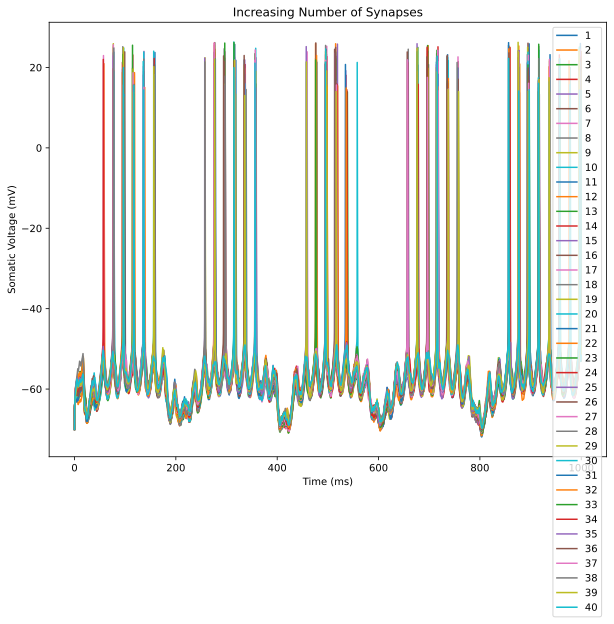

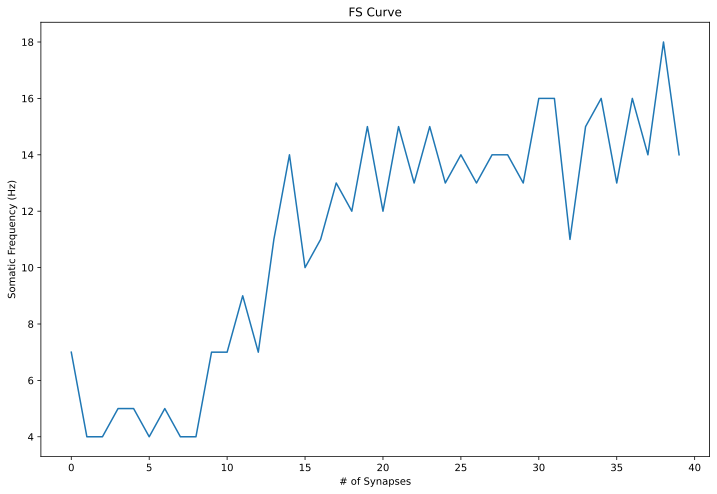

In [ ]:
# FS CURVE FOR THETA BACKGROUND #

# NOTE: FOR NONSYNCHRONOUS POISSION, SEED MUST BE 1

# stim_param = [interval, num, start, noise, seed]
stim_param =   [1000/50,  1e9,   0,     0,     1]

adjust = h.IClamp(h.soma(1))
adjust.delay = 0
adjust.dur = 1e9
adjust.amp = 3.35

num_s = 40

f_1 = increase_syn(branch=h.a1_111, 
                     loc=0.5, 
                     n_syn=num_s,
                     stim=stim_param, 
                     g=[0.0015, 0.0039], 
                     spread=0,
                     firing = [5, 5, 50, 50],
                     g_bg = [0, 0, 0, 0, 0, 0.03],
                     dtb=[20,20, 3],
                     avg=1, 
                     gamma=False,
                     plot=True, 
                     progress_bar=False,
                     stim_spread=0,
                     distribute=False,
                     sync=False,
                     inhib_dend=True)

adjust = None
syn_stim = None
iclamp = None
stim = None
i_c = None
stim_obj = None

ncstim_ = None

In [ ]:
# FS CURVE FOR NOISY CURRENT #

# stim_param = [interval, num, start, noise, seed]
stim_param =   [1000/50,  1e9,   0,     1,     1]

num_s = 40

tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
t = np.linspace(0, h.tstop, int(h.tstop/h.dt))
current = 0.88 + 0.5*np.sin(2*np.pi/20*t)
i_c = h.Vector()
i_c.from_python(current)
stim_obj = h.IClamp(h.soma(0.5))
stim_obj.delay = 0  # ms
stim_obj.dur = 1e9  # ms
i_c.play(stim_obj._ref_amp, tt, True)


f_1 = increase_syn_current(branch=h.a1_111, 
                     loc=0.5, 
                     n_syn=num_s,
                     mean=0,
                     var=0,
                     stim=stim_param, 
                     g=[0.0015, 0.0039], 
                     spread=0,
                     avg=25, 
                     plot=False, 
                     progress_bar=False,
                     stim_spread=0,
                     distribute=False,
                     sync=True)

syn_stim = None
iclamp = None
stim = None
i_c = None

tt = None
current = None
i_c = None
stim_obj = None
ncstim_ = None
tt = None
stim_obj = None
ncstim_ = None

Applying synapses at ~121 µm (243.8985804846295 µm total)


  0%|          | 0/20 [00:00<?, ?it/s]

Text(0, 0.5, 'Somatic Frequency (Hz)')

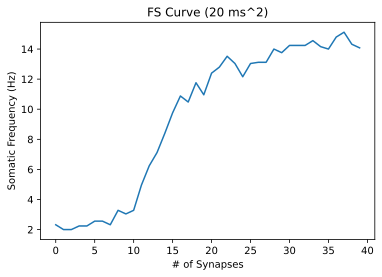

In [ ]:
# PLOTTING FS CURVES 

plt.plot(f_1)
# plt.savefig('FSCurveThetaPoisson.svg')
plt.title('FS Curve (20 ms^2)')
plt.xlabel('# of Synapses')
plt.ylabel('Somatic Frequency (Hz)')

In [ ]:
np.savetxt("INHIBGAMMA_5.csv", f_1, delimiter=",")


In [ ]:
## FI CURVE (THETA BACKGROUND)

# NOTE: MUST CLEAR NCSTIM_, otherwise, there is OVERLAP!

# tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
# t = np.linspace(0, h.tstop, int(h.tstop/h.dt))
# current = 0.88 + 0.5*np.sin(2*np.pi/20*t)
# i_c = h.Vector()
# i_c.from_python(current)
# stim_obj = h.IClamp(h.soma(0.5))
# stim_obj.delay = 0  # ms
# stim_obj.dur = 1e9  # ms
# i_c.play(stim_obj._ref_amp, tt, True)


adjust = h.IClamp(h.soma(1))
adjust.delay = 0
adjust.dur = 1e9
adjust.amp = 3.35

h.v_init = -70

i_1, f_1 = fi_curve(max_c=0.6,
                    inc=0.005,
                    avg=15,
                    g=[0, 0, 0, 0, 0, 0.03],
                    dtb=[20, 20, 3],
                    gamma=False,
                    inhib_dend=True)

ncstim_ = None

syn_stim = None
iclamp = None
stim = None
i_c = None

tt = None
current = None
i_c = None
stim_obj = None
ncstim_ = None
tt = None
stim_obj = None
ncstim_ = None
adjust = None

  0%|          | 0/121 [00:00<?, ?it/s]

In [ ]:
# FI CURVE (NOISY CURRENT)

h.v_init = -70



i_2, f_2 = fi_curve_current(max_c=1,
                           inc=0.05,      
                            avg=1)








  0%|          | 0/21 [00:00<?, ?it/s]

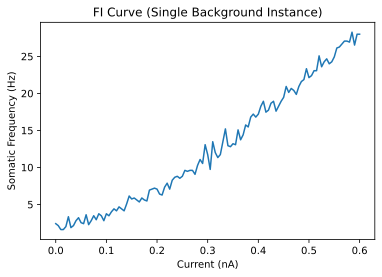

In [ ]:
# FI CURVE PLOT
fig, axs_1 = plt.subplots()

axs_1.plot(i_1, f_1)
axs_1.set_xlabel('Current (nA)')
axs_1.set_ylabel('Somatic Frequency (Hz)')
axs_1.set_title('FI Curve (Single Background Instance)')
# fig.savefig('FICurve.png', dpi=1000)
plt.show()



In [ ]:
np.savetxt("FI_INHIBGAMMA_5.csv", np.vstack((i_1, f_1)).T, delimiter=",")
# np.savetxt("FI_NOISY_freq.csv", f_2, delimiter=",")

In [ ]:
# f_vec_FS = np.loadtxt("FS_NMDAOnly.csv", delimiter=",")
# f_vec_FI = np.loadtxt("FI_NMDAonly_freq.csv", delimiter=",")
# i_vec_FI = np.loadtxt("FI_NMDAonly_current.csv", delimiter=",")

In [ ]:
np.savetxt("IS_NMDAOnly.csv", corr, delimiter=",")

In [ ]:
tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
t = np.linspace(0, h.tstop, int(h.tstop/h.dt))
current = np.sin(2*pi*50*)
i_c = h.Vector()
i_c.from_python(current)
stim_obj = h.IClamp(h.soma(0.5))
stim_obj.delay = 0  # ms
stim_obj.dur = 1e9  # ms
i_c.play(stim_obj._ref_amp, tt, True)